In [1]:
import os
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random
import time

In [2]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (255, 255))  # Assurez-vous que la taille correspond à celle utilisée lors de l'entraînement
    img = img / 255.0  # Normalisez les valeurs des pixels
    img = np.expand_dims(img, axis=0)  # Ajoutez une dimension pour représenter le lot (batch)

    return img

def predict_defect(model, image_path):
    preprocessed_img = load_and_preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)

    # Interprétez la prédiction (1 signifie "OK", 0 signifie "défaut")
    if prediction[0, 0] > 0.5:
        return "OK"
    else:
        return "Défaut"


In [3]:
def load_data_multi_class(dataset_path):
    data = []
    labels = []

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):

            label = folder.lower()  # Utilisez le nom du dossier comme label
            print(label)
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (255, 255))
                data.append(img)
                labels.append(label)

    data = np.array(data) / 255.0
    labels = np.array(labels)

    return data, labels

In [4]:
from keras.models import load_model
#model.save('models/88-83.h5')
model = load_model('models/88-83.h5')
#model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 249, 249, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 121, 121, 128)     131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                                 
 dense (Dense)               (None, 128)               5

In [5]:
def predict_defect_multi_class(model, image_path):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    #print (model.predict(preprocessed_img))

    # Interprétez les prédictions
    class_labels = [ 'OK','bed_not_stick', 'spaghetti']
    predicted_class = class_labels[np.argmax(predictions)]

    return predicted_class

In [6]:
def predict(dir):
    resultf=""
    nb_total=0
    nb_positif=0
    for filename in os.listdir(dir):
        #print(filename)
        nb_total+=1

        result = predict_defect_multi_class(model, dir +"/" + filename)
        if result.upper()==dir[4:].upper():
            nb_positif+=1

        resultf= resultf + "prédiction pour"+ filename + " : "+ str(result) +"\n"

    print (resultf)
    print(str((nb_positif*100)/nb_total) + " % de précision")


In [7]:
predict("testok")

1/1 [==============================] - 0s 63ms/step
prédiction pourok.jpg : OK
prédiction pourok3.jpg : OK
prédiction pourok5.png : spaghetti
prédiction pourspaghetti.jpg : OK
prédiction pourWIN_20231010_15_02_24_Pro.jpg : OK
prédiction pourWIN_20231010_15_02_40_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_00_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_09_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_11_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_18_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_24_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_29_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_56_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_58_Pro.jpg : OK
prédiction pourWIN_20231010_15_04_02_Pro.jpg : OK
prédiction pourWIN_20231010_15_04_05_Pro.jpg : OK

93.75 % de précision


In [8]:
predict("testbed_not_stick")

1/1 [==============================] - 0s 62ms/step
prédiction pourmirror_20231020_154642.jpg : bed_not_stick
prédiction pourmirror_20231020_154647.jpg : OK
prédiction pourmirror_20231020_154657.jpg : bed_not_stick
prédiction pourmirror_20231023_113042.jpg : OK
prédiction pourmirror_20231023_113059.jpg : bed_not_stick
prédiction pourmirror_20231023_113114.jpg : OK
prédiction pourmirror_20231024_145033.jpg : OK
prédiction pourmirror_20231024_145036.jpg : spaghetti
prédiction pourmirror_20231024_145045.jpg : OK
prédiction pourmirror_20231024_145048.jpg : OK
prédiction pourmirror_20231024_145054.jpg : OK
prédiction pourmirror_IMG_20231017_174752.jpg : OK
prédiction pourmirror_IMG_20231024_145904.jpg : OK
prédiction pourmirror_IMG_20231024_145911.jpg : OK
prédiction pourmirror_Screenshot_3.jpg : OK
prédiction pourmirror_Screenshot_4.jpg : OK

18.75 % de précision


In [9]:
predict("testspaghetti")

1/1 [==============================] - 0s 62ms/step
prédiction pour149918_fea6b7ad1f911b19fff8646791e3edc9.jpg : OK
prédiction pour336642593_1586539821825588_2902609152199909802_n_cropped_jpg.rf.2d5aa60a4ff666f611bf9e13600b2c90.jpg : spaghetti
prédiction pourcb7afa69396b8da7b092bcea0337193654a8ae99e3597e58851c8ba742c716e7_1.jpg : spaghetti
prédiction pourDv-Hh80U0AABjlw_jpg.rf.6116d29abb60be092c1930f2765318db.jpg : spaghetti
prédiction pourfailedprint2_img_5eb0af2d67ead.jpg : spaghetti
prédiction pourimag-12-_jpg.rf.30b4d2d01cbe881c76ffb7cd4aa30d4c.jpg : spaghetti
prédiction pourimag-61-_jpg.rf.b10e3a7fad549280a1a405c80d0c800d.jpg : spaghetti
prédiction pourimag-90-_jpg.rf.4b9eacbcb46c3c32db58fb5f7c22ed4c.jpg : spaghetti
prédiction pourspaghetti_11_jpg.rf.8f8ab1a10807e3e51c4075a1a018ce3b.jpg : spaghetti
prédiction pourspaghetti_1_jpg.rf.4b6bc66a3d72ead9fc1592820c153ee8.jpg : spaghetti
prédiction pourspaghetti_49_jpg.rf.2f51e66161f920f5704ae3e81e089435.jpg : spaghetti
prédiction pourspa

In [10]:
from PIL import Image 
import matplotlib.pyplot as plt

def vignette_random(dir):
  L=[]
  for filename in os.listdir(dir):
    L.append(filename)
  file_alea = L[random.randint(0, (len(L)-1))]
  image_path = dir +"/" + file_alea
  result = predict_defect_multi_class(model, image_path)
  img = Image.open(image_path)
  plt.imshow(img)
  plt.axis('off')  # Masquer les axes
  plt.show()

  print (result)


1/1 [==============================] - 0s 57ms/step


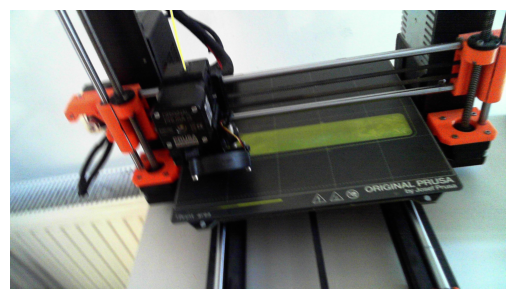

OK


In [11]:
vignette_random("testok")

1/1 [==============================] - 0s 60ms/step


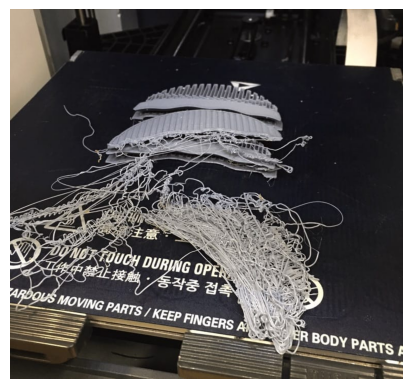

spaghetti


In [12]:
vignette_random("testspaghetti")

1/1 [==============================] - 0s 48ms/step


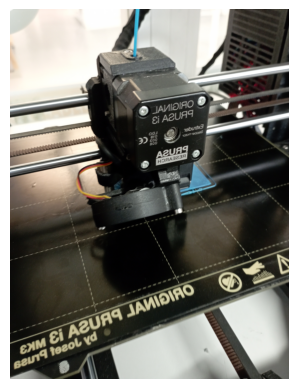

OK


In [13]:
vignette_random("testbed_not_stick")

In [14]:
import datetime

def capture():
  # Ouvrir la webcam (la webcam par défaut a l'ID 0)
  cap = cv2.VideoCapture(1)

  # Vérifier si la webcam est ouverte correctement
  if not cap.isOpened():
      print("Erreur: Impossible d'ouvrir la webcam.")
      exit()

  # Capturer une image
  time.sleep(1)
  ret, frame = cap.read()

  # Sauvegarder l'image capturée
  if ret:
      cv2.imwrite("photo_capturee.jpg", frame)
      print("Photo capturée avec succès.")

      result = predict_defect_multi_class(model, 'photo_capturee.jpg')
      img = Image.open('photo_capturee.jpg')
      plt.imshow(img)
      plt.axis('off')  # Masquer les axes
      now = datetime.datetime.now().strftime("%H:%M:%S")
      

      plt.show()
      print(f"Prédiction pour la capture caméra : {result}")
      print(f"à {now}")
  
  
  else:
      print("Erreur lors de la capture de la photo.")

  # Libérer la webcam
  cap.release()



Photo capturée avec succès.
1/1 [==============================] - 0s 92ms/step


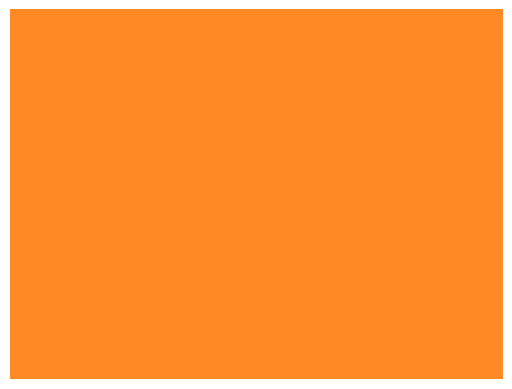

Prédiction pour la capture caméra : spaghetti
à 14:57:37


In [23]:
capture()

In [16]:
def capture_boucle():
    try:
        while True:
            # Exécute la fonction capture()
            capture()
            print()

            
            # Pause de x secondes
            time.sleep(5)

    except KeyboardInterrupt:
        print("\nInterruption de l'utilisateur. Fin du script.")

Photo capturée avec succès.
1/1 [==============================] - 0s 70ms/step


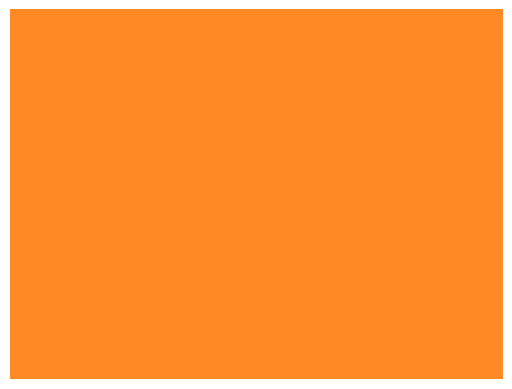

Prédiction pour la capture caméra : spaghetti
à 14:46:28

Photo capturée avec succès.
1/1 [==============================] - 0s 51ms/step


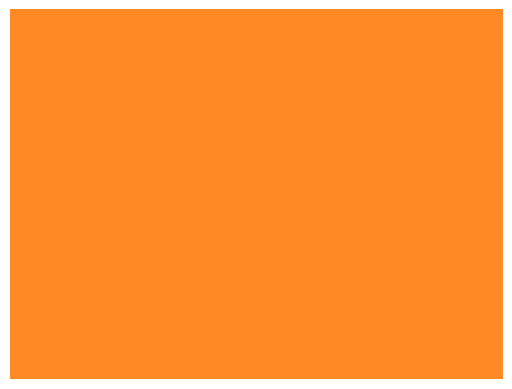

Prédiction pour la capture caméra : spaghetti
à 14:46:34

Photo capturée avec succès.
1/1 [==============================] - 0s 66ms/step


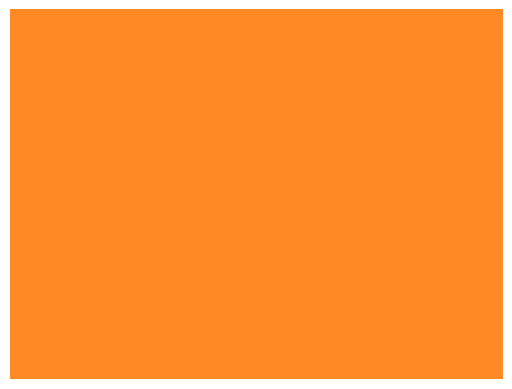

Prédiction pour la capture caméra : spaghetti
à 14:46:41

Photo capturée avec succès.
1/1 [==============================] - 0s 50ms/step


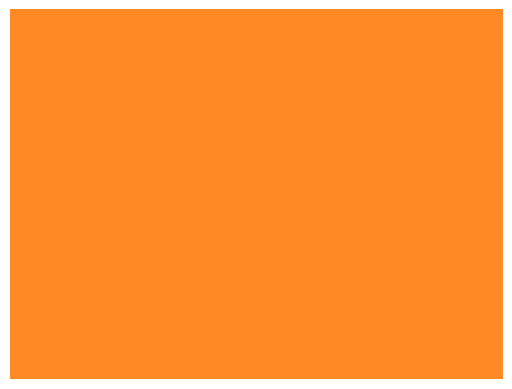

Prédiction pour la capture caméra : spaghetti
à 14:46:47

Photo capturée avec succès.
1/1 [==============================] - 0s 58ms/step


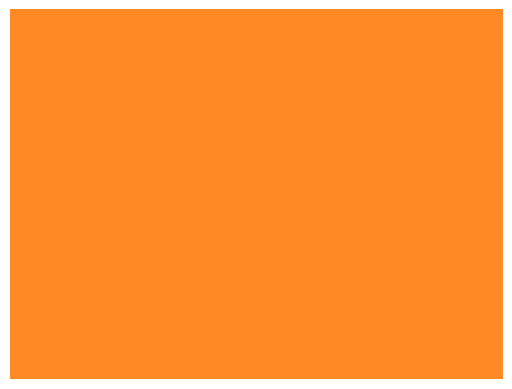

Prédiction pour la capture caméra : spaghetti
à 14:46:53

Photo capturée avec succès.
1/1 [==============================] - 0s 68ms/step


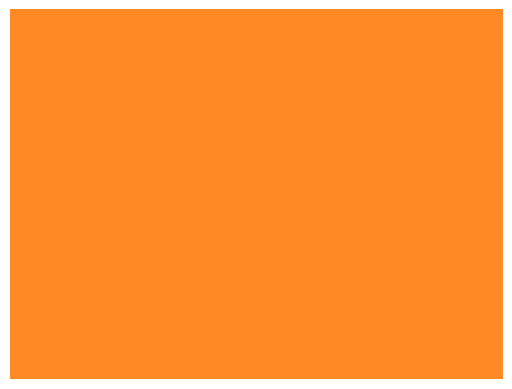

Prédiction pour la capture caméra : spaghetti
à 14:47:00

Photo capturée avec succès.
1/1 [==============================] - 0s 47ms/step


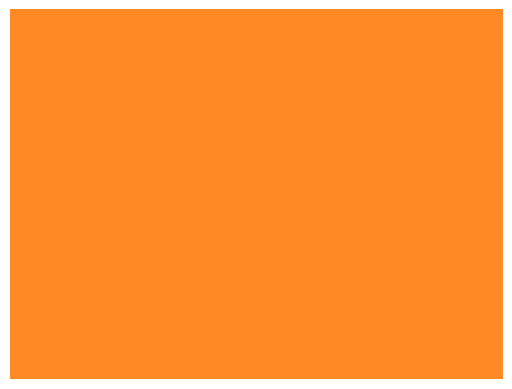

Prédiction pour la capture caméra : spaghetti
à 14:47:06

Photo capturée avec succès.
1/1 [==============================] - 0s 47ms/step


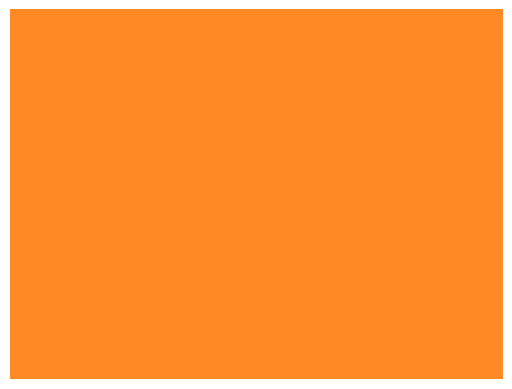

Prédiction pour la capture caméra : spaghetti
à 14:47:12

Photo capturée avec succès.
1/1 [==============================] - 0s 65ms/step


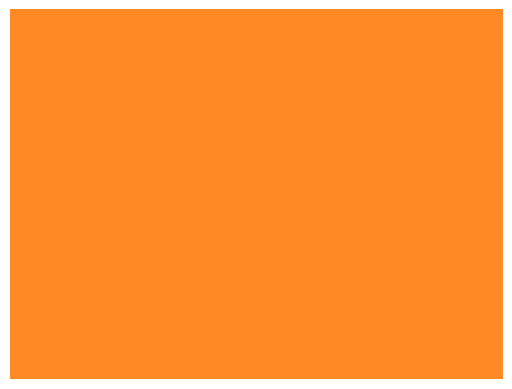

Prédiction pour la capture caméra : spaghetti
à 14:47:18

Photo capturée avec succès.
1/1 [==============================] - 0s 67ms/step


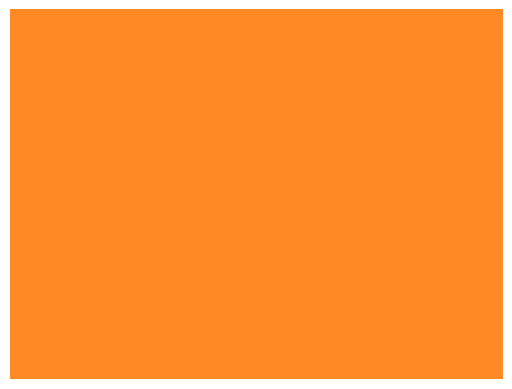

Prédiction pour la capture caméra : spaghetti
à 14:47:25

Photo capturée avec succès.
1/1 [==============================] - 0s 64ms/step


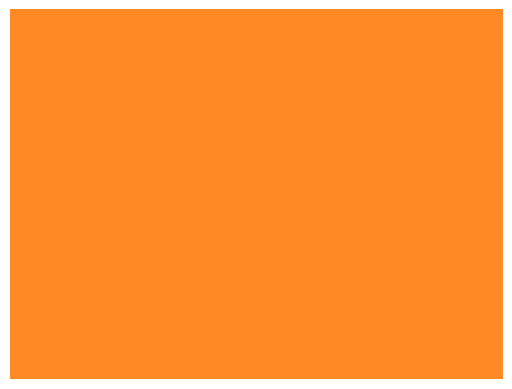

Prédiction pour la capture caméra : spaghetti
à 14:47:31

Photo capturée avec succès.
1/1 [==============================] - 0s 65ms/step


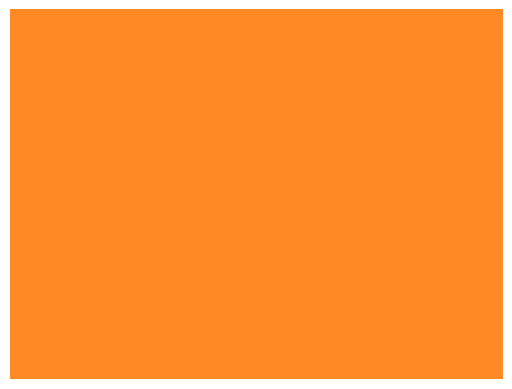

Prédiction pour la capture caméra : spaghetti
à 14:47:37

Photo capturée avec succès.
1/1 [==============================] - 0s 50ms/step


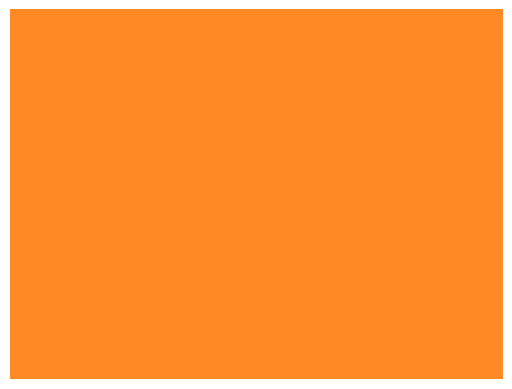

Prédiction pour la capture caméra : spaghetti
à 14:47:44

Photo capturée avec succès.
1/1 [==============================] - 0s 66ms/step


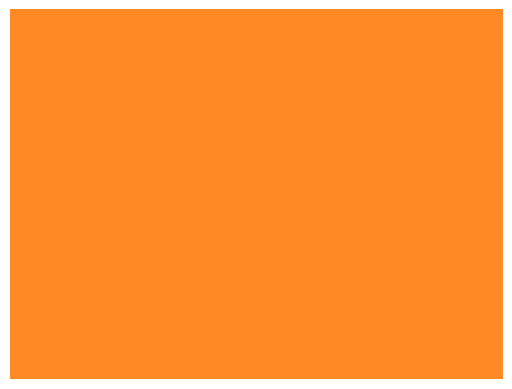

Prédiction pour la capture caméra : spaghetti
à 14:47:50

Photo capturée avec succès.
1/1 [==============================] - 0s 70ms/step


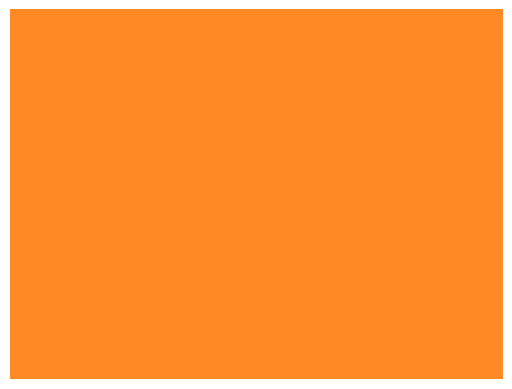

Prédiction pour la capture caméra : spaghetti
à 14:47:56

Photo capturée avec succès.
1/1 [==============================] - 0s 50ms/step


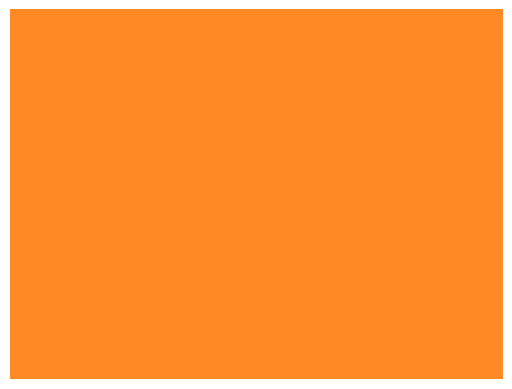

Prédiction pour la capture caméra : spaghetti
à 14:48:03

Photo capturée avec succès.
1/1 [==============================] - 0s 63ms/step


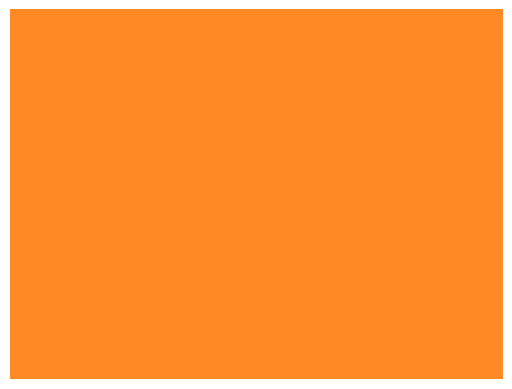

Prédiction pour la capture caméra : spaghetti
à 14:48:09

Photo capturée avec succès.
1/1 [==============================] - 0s 95ms/step


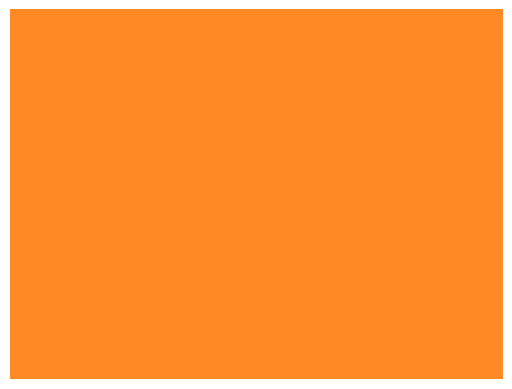

Prédiction pour la capture caméra : spaghetti
à 14:48:15

Photo capturée avec succès.
1/1 [==============================] - 0s 66ms/step


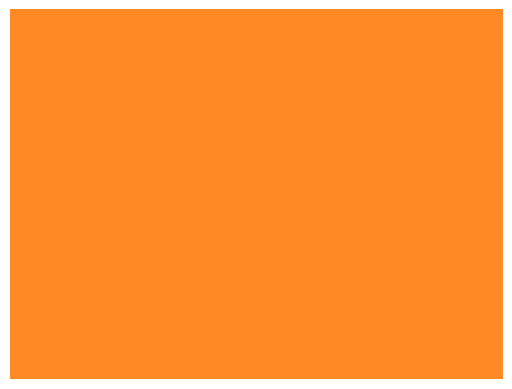

Prédiction pour la capture caméra : spaghetti
à 14:48:22

Photo capturée avec succès.
1/1 [==============================] - 0s 62ms/step


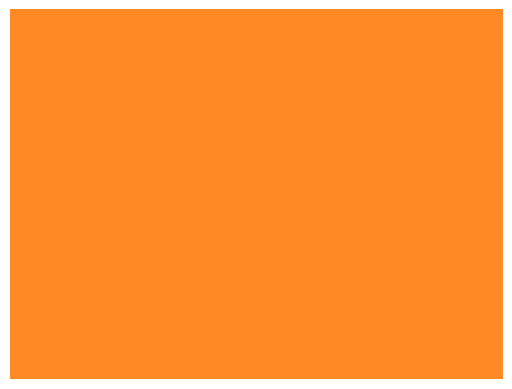

Prédiction pour la capture caméra : spaghetti
à 14:48:28

Photo capturée avec succès.
1/1 [==============================] - 0s 67ms/step


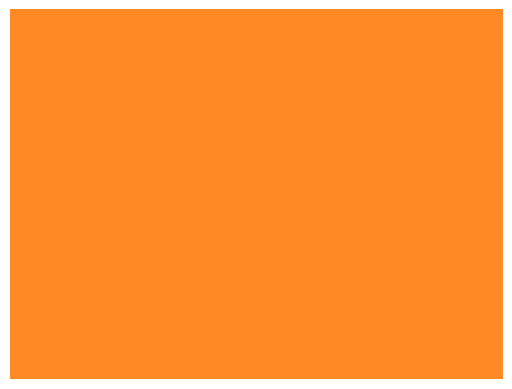

Prédiction pour la capture caméra : spaghetti
à 14:48:34


Interruption de l'utilisateur. Fin du script.


In [17]:
#capture_boucle()